In [1]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("invoices.csv", error_bad_lines=False)

In [3]:
data

,invoice_id,user_id,plan_id,plan_amount,amount,trans_id,original_trans_id,location,discount,method,device_type,status,created_date,last_update
0,134,130,17,3,3,NaN,NaN,NaN,0,coin,android,1,2015-05-14 15:22:14,2015-05-14 15:22:14
1,136,62638,17,3,3,NaN,NaN,NaN,0,coin,android,1,2015-05-14 18:14:48,2015-05-14 18:14:48
2,137,74,17,3,3,NaN,NaN,NaN,0,coin,ios,1,2015-05-15 08:23:43,2015-05-15 08:23:43
3,138,61799,17,3,3,NaN,NaN,NaN,0,coin,web,1,2015-05-15 09:40:07,2015-05-15 09:40:07
4,139,61799,17,3,3,NaN,NaN,NaN,0,coin,web,1,2015-05-15 09:40:09,2015-05-15 09:40:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501366,4485531,5131249,1731,67,67,1000000583484887,NaN,othe,0,direct,ios,1,2019-10-24 16:16:34,2019-10-24 16:16:34
1501367,4485532,5131249,1730,67,67,1000000583488178,NaN,othe,0,direct,ios,1,2019-10-24 16:20:07,2019-10-24 16:20:07
1501368,4485533,5131249,1731,67,67,1000000583489713,NaN,othe,0,direct,ios,1,2019-10-24 16:20:51,2019-10-24 16:20:51
1501369,4485534,5131249,1730,67,67,1000000583500955,NaN,othe,0,direct,NaN,1,2019-10-24 16:35:18,2019-10-24 16:35:18


In [4]:
data = data[['invoice_id', 'user_id','plan_amount','amount','trans_id','discount', 'method', 'device_type', 'status', 'created_date', 'last_update']]

In [5]:
data = data[pd.notnull(data['user_id'])]
data = data[data['status'] == 1]
data['created_date'] = pd.to_datetime(data['created_date']).dt.date
data['time'] = data['last_update']
data['time'] = pd.to_datetime(data['time']).dt.date
data['user_id'] = data['user_id'].astype(str)
data = data[(data['amount']>0)]
# data

In [6]:
# data.method.value_counts()[:10].plot(kind='bar')

In [7]:
PRESENT = dt.datetime.now().date()
PRESENT

datetime.date(2019, 10, 25)

In [8]:
rfm = data.groupby('user_id').agg({'created_date': lambda date: (PRESENT - date.max()).days,
                                        'invoice_id': lambda num: len(num),
                                        'amount': lambda price: price.sum(),
                                        'time': lambda d: (PRESENT - d.min()).days
                                       })

In [9]:
# Change the name of columns
rfm.columns=['recency','frequency','monetary', 'time']

In [10]:
rfm['recency'] = rfm['recency'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(int)
rfm['time'] = rfm['time'].astype(int)

In [11]:
rfm.describe()

,recency,frequency,monetary,time
count,134416.000000,134416.000000,134416.000000,134416.000000
mean,714.008422,3.686444,141.052174,768.432865
std,347.894892,16.261230,584.320724,358.850546
min,1.000000,1.000000,1.000000,1.000000
25%,426.000000,1.000000,30.000000,455.000000
50%,630.000000,1.000000,50.000000,692.000000
75%,951.250000,2.000000,100.000000,1028.000000
max,1624.000000,379.000000,40000.000000,1625.000000


In [12]:
# rfm['r_score'] = pd.cut(rfm['recency'], 5, ['5', '4', '3', '2', '1'])
# rfm['f_score'] = pd.cut(rfm['frequency'], 5, ['1', '2', '3', '4', '5'])
# rfm['m_score'] = pd.cut(rfm['monetary'], 5, ['1', '2', '3', '4', '5'])
# rfm['t_score'] = pd.cut(rfm['time'], 5, ['1', '2', '3', '4', '5'])


rlabels = ['5', '4', '3', '2', '1']
flabels = ['1', '2', '3', '4', '5']
mlabels = ['1', '2', '3', '4', '5']
tlabels = ['1', '2', '3', '4', '5']

rfm['r_score'] = pd.cut(rfm['recency'], len(rlabels), labels=rlabels)
rfm['f_score'] = pd.cut(rfm['frequency'], len(flabels),labels=flabels)
rfm['m_score'] = pd.cut(rfm['monetary'], len(mlabels), labels=mlabels)
rfm['t_score'] = pd.cut(rfm['time'], len(tlabels), labels=tlabels)

In [13]:
# rfm['r_score'].value_counts()
# rfm['f_score'].value_counts()
# rfm['m_score'].value_counts()
rfm['t_score'].value_counts()

2    56521
3    35096
4    23368
5    15324
1     4107
Name: t_score, dtype: int64

In [14]:
rfm

,recency,frequency,monetary,time,r_score,f_score,m_score,t_score
user_id,,,,,,,,
1,18,1,230,18,5,1,1,1
1000082,1408,1,3,1408,1,1,1,5
1000211,1429,1,3,1429,1,1,1,5
10002237,116,1,230,116,5,1,1,1
1000246,986,1,100,986,2,1,1,4
...,...,...,...,...,...,...,...,...
99982,614,1,29,614,4,1,1,2
999834,390,1,50,390,4,1,1,2
99985,592,6,1120,885,4,1,1,3


In [15]:
rfm['RFM_Score'] = rfm.r_score.astype(str)+ rfm.f_score.astype(str) + rfm.f_score.astype(str)
rfm['RFM_Score'] = rfm.RFM_Score.astype(int)
rfm.head()

,recency,frequency,monetary,time,r_score,f_score,m_score,t_score,RFM_Score
user_id,,,,,,,,,
1,18,1,230,18,5,1,1,1,511
1000082,1408,1,3,1408,1,1,1,5,111
1000211,1429,1,3,1429,1,1,1,5,111
10002237,116,1,230,116,5,1,1,1,511
1000246,986,1,100,986,2,1,1,4,211


In [16]:
def type_of_customer(row):
    if row.RFM_Score in [555, 554, 544, 545, 454, 455, 445]:
        return 'Champions'
    elif row.RFM_Score in [543, 444, 435, 355, 354, 345, 344, 335]:
        return 'Loyal'
    elif row.RFM_Score in [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323]:
        return 'Potential Loyalist'
    elif row.RFM_Score in [512, 511, 422, 421, 412, 411, 311]:
        return 'New Customers'
    elif row.RFM_Score in [525, 524, 523, 522, 521, 515, 514, 513, 425 ,424, 413, 414, 415, 315, 314, 313]:
        return 'Promising'
    elif row.RFM_Score in [535, 534, 443, 434, 343, 334, 325, 324]:
        return 'Need Attention'
    elif row.RFM_Score in [331, 321, 312, 221, 213, 231, 241, 251]:
        return 'About To Sleep'
    elif row.RFM_Score in [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124]:
        return 'At Risk'
    elif row.RFM_Score in [155, 154, 144, 214, 215 ,115, 114, 113]:
        return 'Cannot Lose Them'
    elif row.RFM_Score in [332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211]:
        return 'Hibernating customers'
    elif row.RFM_Score in [111, 112, 121, 131, 141, 151]:
        return 'Lost customers'
    return 'unknown'

In [17]:
rfm['CustomerSegment'] = rfm.apply(type_of_customer, axis=1)
rfm.head()

,recency,frequency,monetary,time,r_score,f_score,m_score,t_score,RFM_Score,CustomerSegment
user_id,,,,,,,,,,
1,18,1,230,18,5,1,1,1,511,New Customers
1000082,1408,1,3,1408,1,1,1,5,111,Lost customers
1000211,1429,1,3,1429,1,1,1,5,111,Lost customers
10002237,116,1,230,116,5,1,1,1,511,New Customers
1000246,986,1,100,986,2,1,1,4,211,Hibernating customers


In [18]:
rfm.groupby('CustomerSegment').CustomerSegment.count()

CustomerSegment
Champions                   133
Hibernating customers     20646
Lost customers            11844
Loyal                       117
New Customers            101530
Potential Loyalist          142
Promising                     4
Name: CustomerSegment, dtype: int64

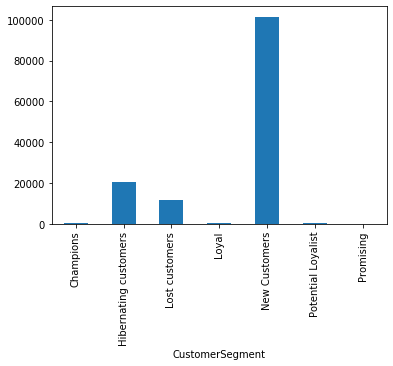

In [19]:
rfm.groupby('CustomerSegment').CustomerSegment.count().plot(kind='bar')

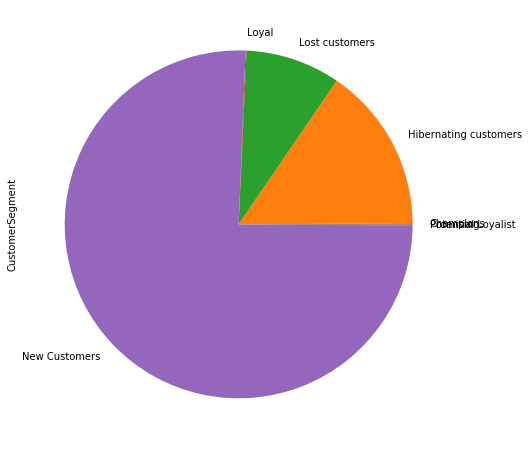

In [20]:
a = rfm.CustomerSegment.groupby(rfm.CustomerSegment).size()
a.plot.pie(y = '', figsize=(8,8))

In [21]:
rfm['RFM_Score_Formular'] = np.sqrt(rfm.monetary) * rfm.frequency * 1/(rfm.recency * 60)

In [22]:
rfm

,recency,frequency,monetary,time,r_score,f_score,m_score,t_score,RFM_Score,CustomerSegment,RFM_Score_Formular
user_id,,,,,,,,,,,
1,18,1,230,18,5,1,1,1,511,New Customers,0.014042
1000082,1408,1,3,1408,1,1,1,5,111,Lost customers,0.000021
1000211,1429,1,3,1429,1,1,1,5,111,Lost customers,0.000020
10002237,116,1,230,116,5,1,1,1,511,New Customers,0.002179
1000246,986,1,100,986,2,1,1,4,211,Hibernating customers,0.000169
...,...,...,...,...,...,...,...,...,...,...,...
99982,614,1,29,614,4,1,1,2,411,New Customers,0.000146
999834,390,1,50,390,4,1,1,2,411,New Customers,0.000302
99985,592,6,1120,885,4,1,1,3,411,New Customers,0.005653
